In [1]:
#learn kung fu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import mason_functions as mf

import os
import evaluate
import warnings
warnings.filterwarnings('ignore')

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import wrangle

In [2]:
#define my sql query to access the relational database
sql = '''
SELECT parcelid, fips, bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt
FROM predictions_2017
LEFT JOIN properties_2017 USING(parcelid)
JOIN propertylandusetype USING(propertylandusetypeid)
WHERE propertylandusetypeid = 261 or propertylandusetypeid = 279
'''

#define my url
url = mf.get_db_url('zillow')

#read the information from a database into a dataframe
#I also will not continuously query the database; instead, I will write the data to a .csv (in case the kernel gotta go)
if os.path.isfile('zillow_nadir.csv'):
    df = pd.read_csv('zillow_nadir.csv', index_col = 0)
else:
    df = pd.read_sql(sql, url)
    df.to_csv('zillow_nadir.csv')

In [3]:
#at a glance
pd.options.display.max_columns = 69
pd.options.display.max_rows = 69
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52442 non-null  int64  
 1   fips                          52442 non-null  float64
 2   bathroomcnt                   52442 non-null  float64
 3   bedroomcnt                    52442 non-null  float64
 4   calculatedfinishedsquarefeet  52360 non-null  float64
 5   taxvaluedollarcnt             52441 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 2.8 MB


In [4]:
#double-take
df.head()

,parcelid,fips,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt
0,14297519,6059.0,3.5,4.0,3100.0,1023282.0
1,17052889,6111.0,1.0,2.0,1465.0,464000.0
2,14186244,6059.0,2.0,3.0,1243.0,564778.0
3,12177905,6037.0,3.0,4.0,2376.0,145143.0
4,12095076,6037.0,3.0,4.0,2962.0,773303.0


In [5]:
#ok, this hurts to look at. rename the columns
df = df.rename(columns = {'parcelid': 'parcel_id',
                          'fips': 'fips_id',
                          'bathroomcnt': 'bathroom_count',
                          'bedroomcnt': 'bedroom_count',
                          'calculatedfinishedsquarefeet': 'square_footage',
                          'taxvaluedollarcnt': 'tax_value'
                          })

In [6]:
#summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcel_id,52442.0,1.299912e+07,3.411412e+06,10711855.0,11510295.5,12577655.0,14129510.25,167687839.0
fips_id,52442.0,6.049132e+03,2.102893e+01,6037.0,6037.0,6037.0,6059.00,6111.0
bathroom_count,52442.0,2.299397e+00,1.022764e+00,0.0,2.0,2.0,3.00,18.0
bedroom_count,52442.0,3.300675e+00,9.490858e-01,0.0,3.0,3.0,4.00,14.0
square_footage,52360.0,1.922874e+03,1.004363e+03,128.0,1268.0,1659.0,2306.00,21929.0
tax_value,52441.0,5.296830e+05,7.518883e+05,1000.0,193750.0,373612.0,619301.00,49061236.0


In [7]:
#Nulls?
df.isnull().any()

parcel_id         False
fips_id           False
bathroom_count    False
bedroom_count     False
square_footage     True
tax_value          True
dtype: bool

In [8]:
#how many nulls and where?
df.isnull().sum()

parcel_id          0
fips_id            0
bathroom_count     0
bedroom_count      0
square_footage    82
tax_value          1
dtype: int64

In [9]:
#quick reminder on total number observations
mf.add_commas(len(df))

'52,442'

In [10]:
#okay, yeah, I do not need these 82 observations out of 50K total
#I will drop the row where the target value is null, because I cannot fathom a use for it at the moment
df = df[df.square_footage.notnull()]
df = df[df.tax_value.notnull()]

In [11]:
#confirm dropped rows
mf.add_commas(len(df))

'52,359'

In [12]:
#let's take another look
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52359 entries, 0 to 52441
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   parcel_id       52359 non-null  int64  
 1   fips_id         52359 non-null  float64
 2   bathroom_count  52359 non-null  float64
 3   bedroom_count   52359 non-null  float64
 4   square_footage  52359 non-null  float64
 5   tax_value       52359 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 2.8 MB


In [13]:
#this doesn't need to be a float, it is a categorical variable
df.fips_id = df.fips_id.astype(int)

In [14]:
#new index
df = df.set_index('parcel_id')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52359 entries, 14297519 to 13083743
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fips_id         52359 non-null  int64  
 1   bathroom_count  52359 non-null  float64
 2   bedroom_count   52359 non-null  float64
 3   square_footage  52359 non-null  float64
 4   tax_value       52359 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 2.4 MB


In [16]:
#data is prepped. Let's make a function
def acq_zillow_nadir():
        
    '''
    This function reads the data from a database into a dataframe.
    I also will not continuously query the database; instead, I will write the data to a .csv (in case the kernel gotta go)
    '''
    
    #define my sql query
    sql = '''
    SELECT parcelid, fips, bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt
    FROM predictions_2017
    LEFT JOIN properties_2017 USING(parcelid)
    JOIN propertylandusetype USING(propertylandusetypeid)
    WHERE propertylandusetypeid = 261 or propertylandusetypeid = 279
    '''

    #define my url using a url-retrieval function from my personal .py
    url = mf.get_db_url('zillow')

    #set up an if-conditional to see if there is a .csv readily available
    if os.path.isfile('zillow_nadir.csv'):
        
        #if there is, render a workable dataframe from the .csv
        df = pd.read_csv('zillow_nadir.csv', index_col = 0)
        
    #if not, access the relational database, and then write data to a .csv for later ease of access
    else:
        df = pd.read_sql(sql, url)
        df.to_csv('zillow_nadir.csv')
    
    #return the dataframe
    return df

In [17]:
#let's do it again
def clean_zillow_nadir():
    '''
    This function acquires my zillow data, drops any observations where the values are missing, and renames the columns so that they are easier to work with.
    '''
    zillow_nadir = acq_zillow_nadir()
    zillow_nadir = zillow_nadir.rename(columns = {'parcelid': 'parcel_id',
                          'fips': 'fips_id',
                          'bathroomcnt': 'bathroom_count',
                          'bedroomcnt': 'bedroom_count',
                          'calculatedfinishedsquarefeet': 'square_footage',
                          'taxvaluedollarcnt': 'tax_value'
                          })
    zillow_nadir.fips_id = zillow_nadir.fips_id.astype(int)
    zillow_nadir = zillow_nadir.set_index('parcel_id')
    zillow_nadir = zillow_nadir[zillow_nadir.square_footage.notnull()]
    zillow_nadir = zillow_nadir[zillow_nadir.tax_value.notnull()]
    
    return zillow_nadir

In [18]:
#one more time
def prep_zillow_nadir():
    #clean the dataframe
    zillow_nadir = clean_zillow_nadir()
    
    #split the data with a function from my personal .py
    train, validate, test = mf.split_data(zillow_nadir)
    
    #return the data
    return train, validate, test

In [19]:
#test wrangle
train, validate, test = wrangle.prep_zillow_nadir()

In [20]:
#check shapes - looks clear
train.shape, validate.shape, test.shape

((29320, 5), (12567, 5), (10472, 5))

In [21]:
#define numeric columns
quant_vars = ['bathroom_count', 'bedroom_count', 'square_footage']

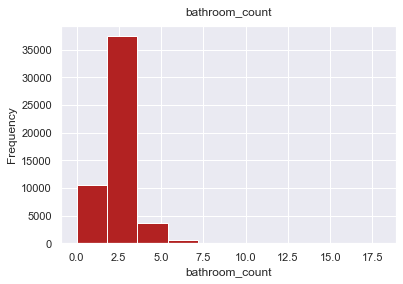

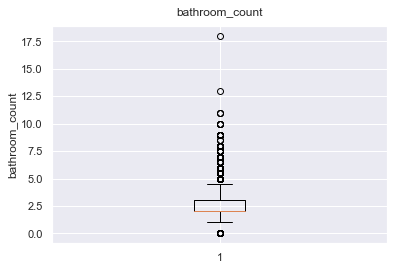

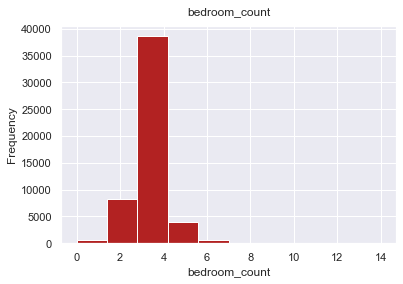

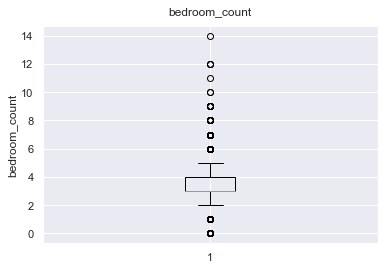

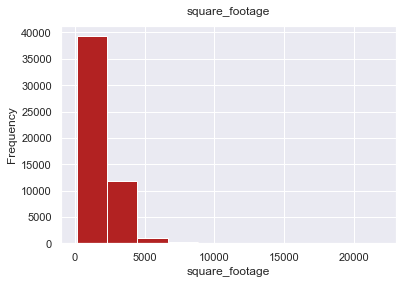

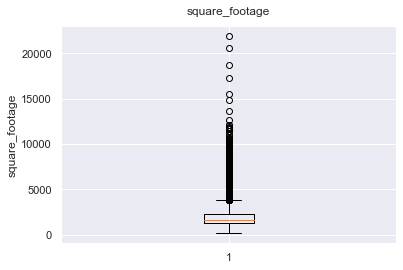

<Figure size 432x288 with 0 Axes>

In [71]:
#distributions
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))
sns.set()
for cat in quant_vars:
    df[cat].hist(color = 'firebrick')
    plt.title(cat, pad = 11)
    plt.xlabel(cat)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show();
    plt.boxplot(df[cat])
    plt.title(cat, pad = 11)
    plt.ylabel(cat)
    plt.grid(True)
    plt.show()
    plt.tight_layout();

Ok yea let's use a robust scaler to handle those outliers

In [60]:
def plot_variable_pairs(train):
    corr1, p1 = stats.pearsonr(train[quant_vars[0]], train[quant_vars[1]])
    corr2, p2 = stats.pearsonr(train[quant_vars[0]], train[quant_vars[2]])
    corr3, p3 = stats.pearsonr(train[quant_vars[1]], train[quant_vars[2]])
    sns.lmplot(x = quant_vars[0], y = quant_vars[1], data = train, line_kws = {'color': 'purple'})
    plt.title(f'R-value: {round(corr1, 3)} | P-value: {p1} \n -----------------');
    sns.lmplot(x = quant_vars[0], y = quant_vars[2], data = train, line_kws = {'color': 'purple'})
    plt.title(f'R-value: {round(corr2, 3)} | P-value: {p2} \n -----------------');
    sns.lmplot(x = quant_vars[1], y = quant_vars[2], data = train, line_kws = {'color': 'purple'})
    plt.title(f'R-value: {round(corr3, 3)} | P-value: {p3} \n -----------------');

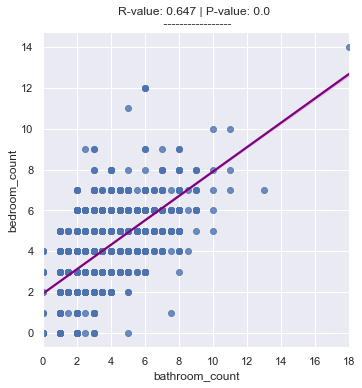

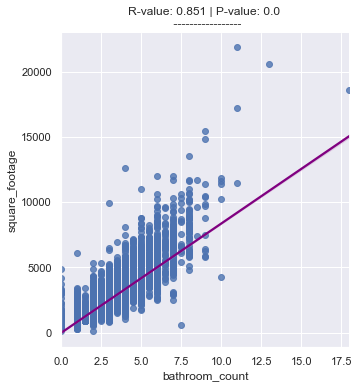

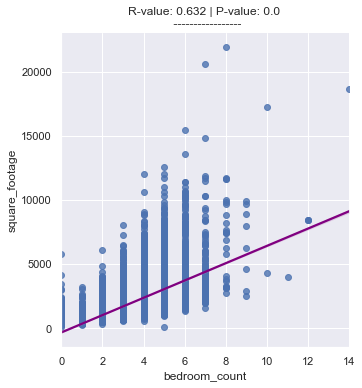

In [72]:
plot_variable_pairs(df)

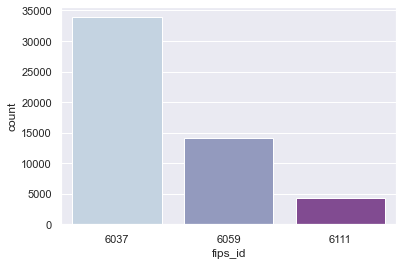

In [25]:
#view distribution across counties
sns.countplot(x = 'fips_id', data = df, palette = 'BuPu');

In [26]:
cat_vars = ['fips_id']

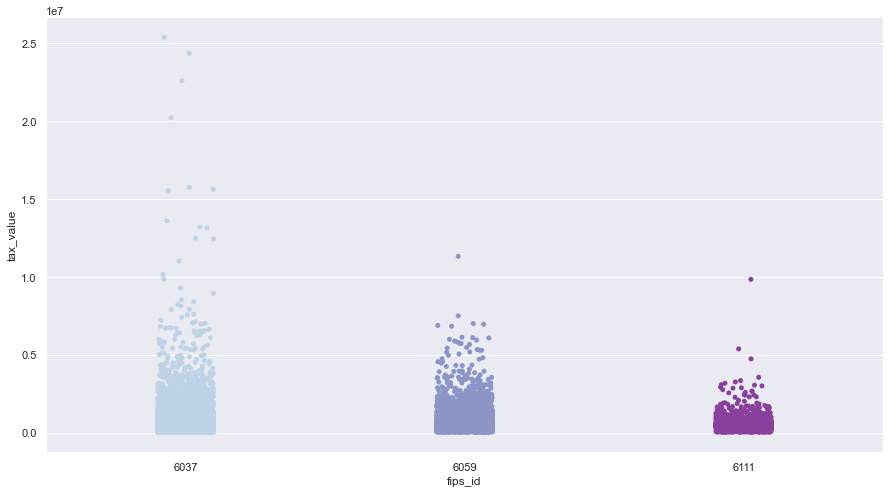

In [73]:
#target variable visualized across counties
plt.figure(figsize = (15, 8))
sns.stripplot(x = 'fips_id', y = 'tax_value', data = train, palette = 'BuPu');

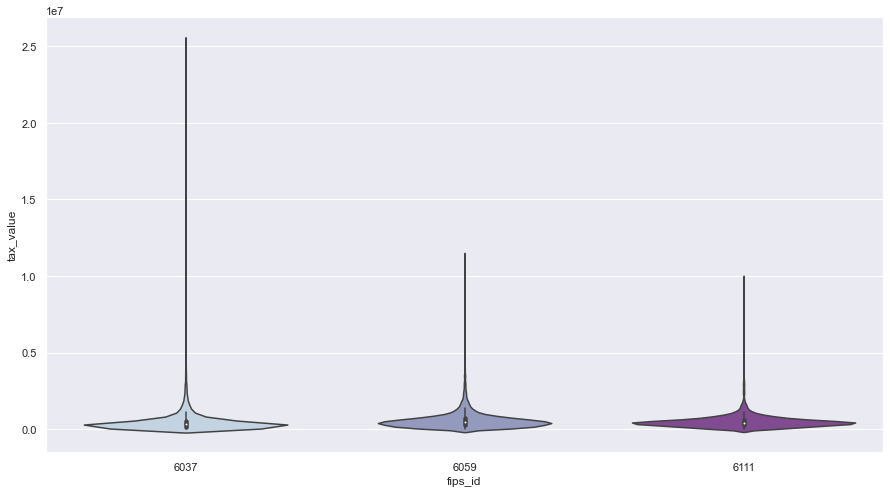

In [62]:
#target variable visualized across counties
plt.figure(figsize = (15, 8))
sns.violinplot(x = 'fips_id', y = 'tax_value', data = train, palette = 'BuPu');

### Are houses priced higher on average in one county over another?

In [56]:
los_angeles_county = df[df.fips_id == 6037]
orange_county = df[df.fips_id == 6059]
ventura_county = df[df.fips_id == 6111]

In [76]:
los_angeles_county.tax_value.describe()

count    3.389300e+04
mean     4.997167e+05
std      8.258084e+05
min      1.000000e+03
25%      1.648360e+05
50%      3.235590e+05
75%      5.524700e+05
max      4.906124e+07
Name: tax_value, dtype: float64

In [64]:
orange_county.tax_value.describe()

count    1.408400e+04
mean     6.003651e+05
std      6.069977e+05
min      1.352400e+04
25%      2.742335e+05
50%      4.723170e+05
75%      7.270000e+05
max      1.131768e+07
Name: tax_value, dtype: float64

In [65]:
ventura_county.tax_value.describe()

count    4.382000e+03
mean     5.144217e+05
std      4.573479e+05
min      9.242000e+03
25%      2.860598e+05
50%      4.425680e+05
75%      6.319632e+05
max      1.319825e+07
Name: tax_value, dtype: float64

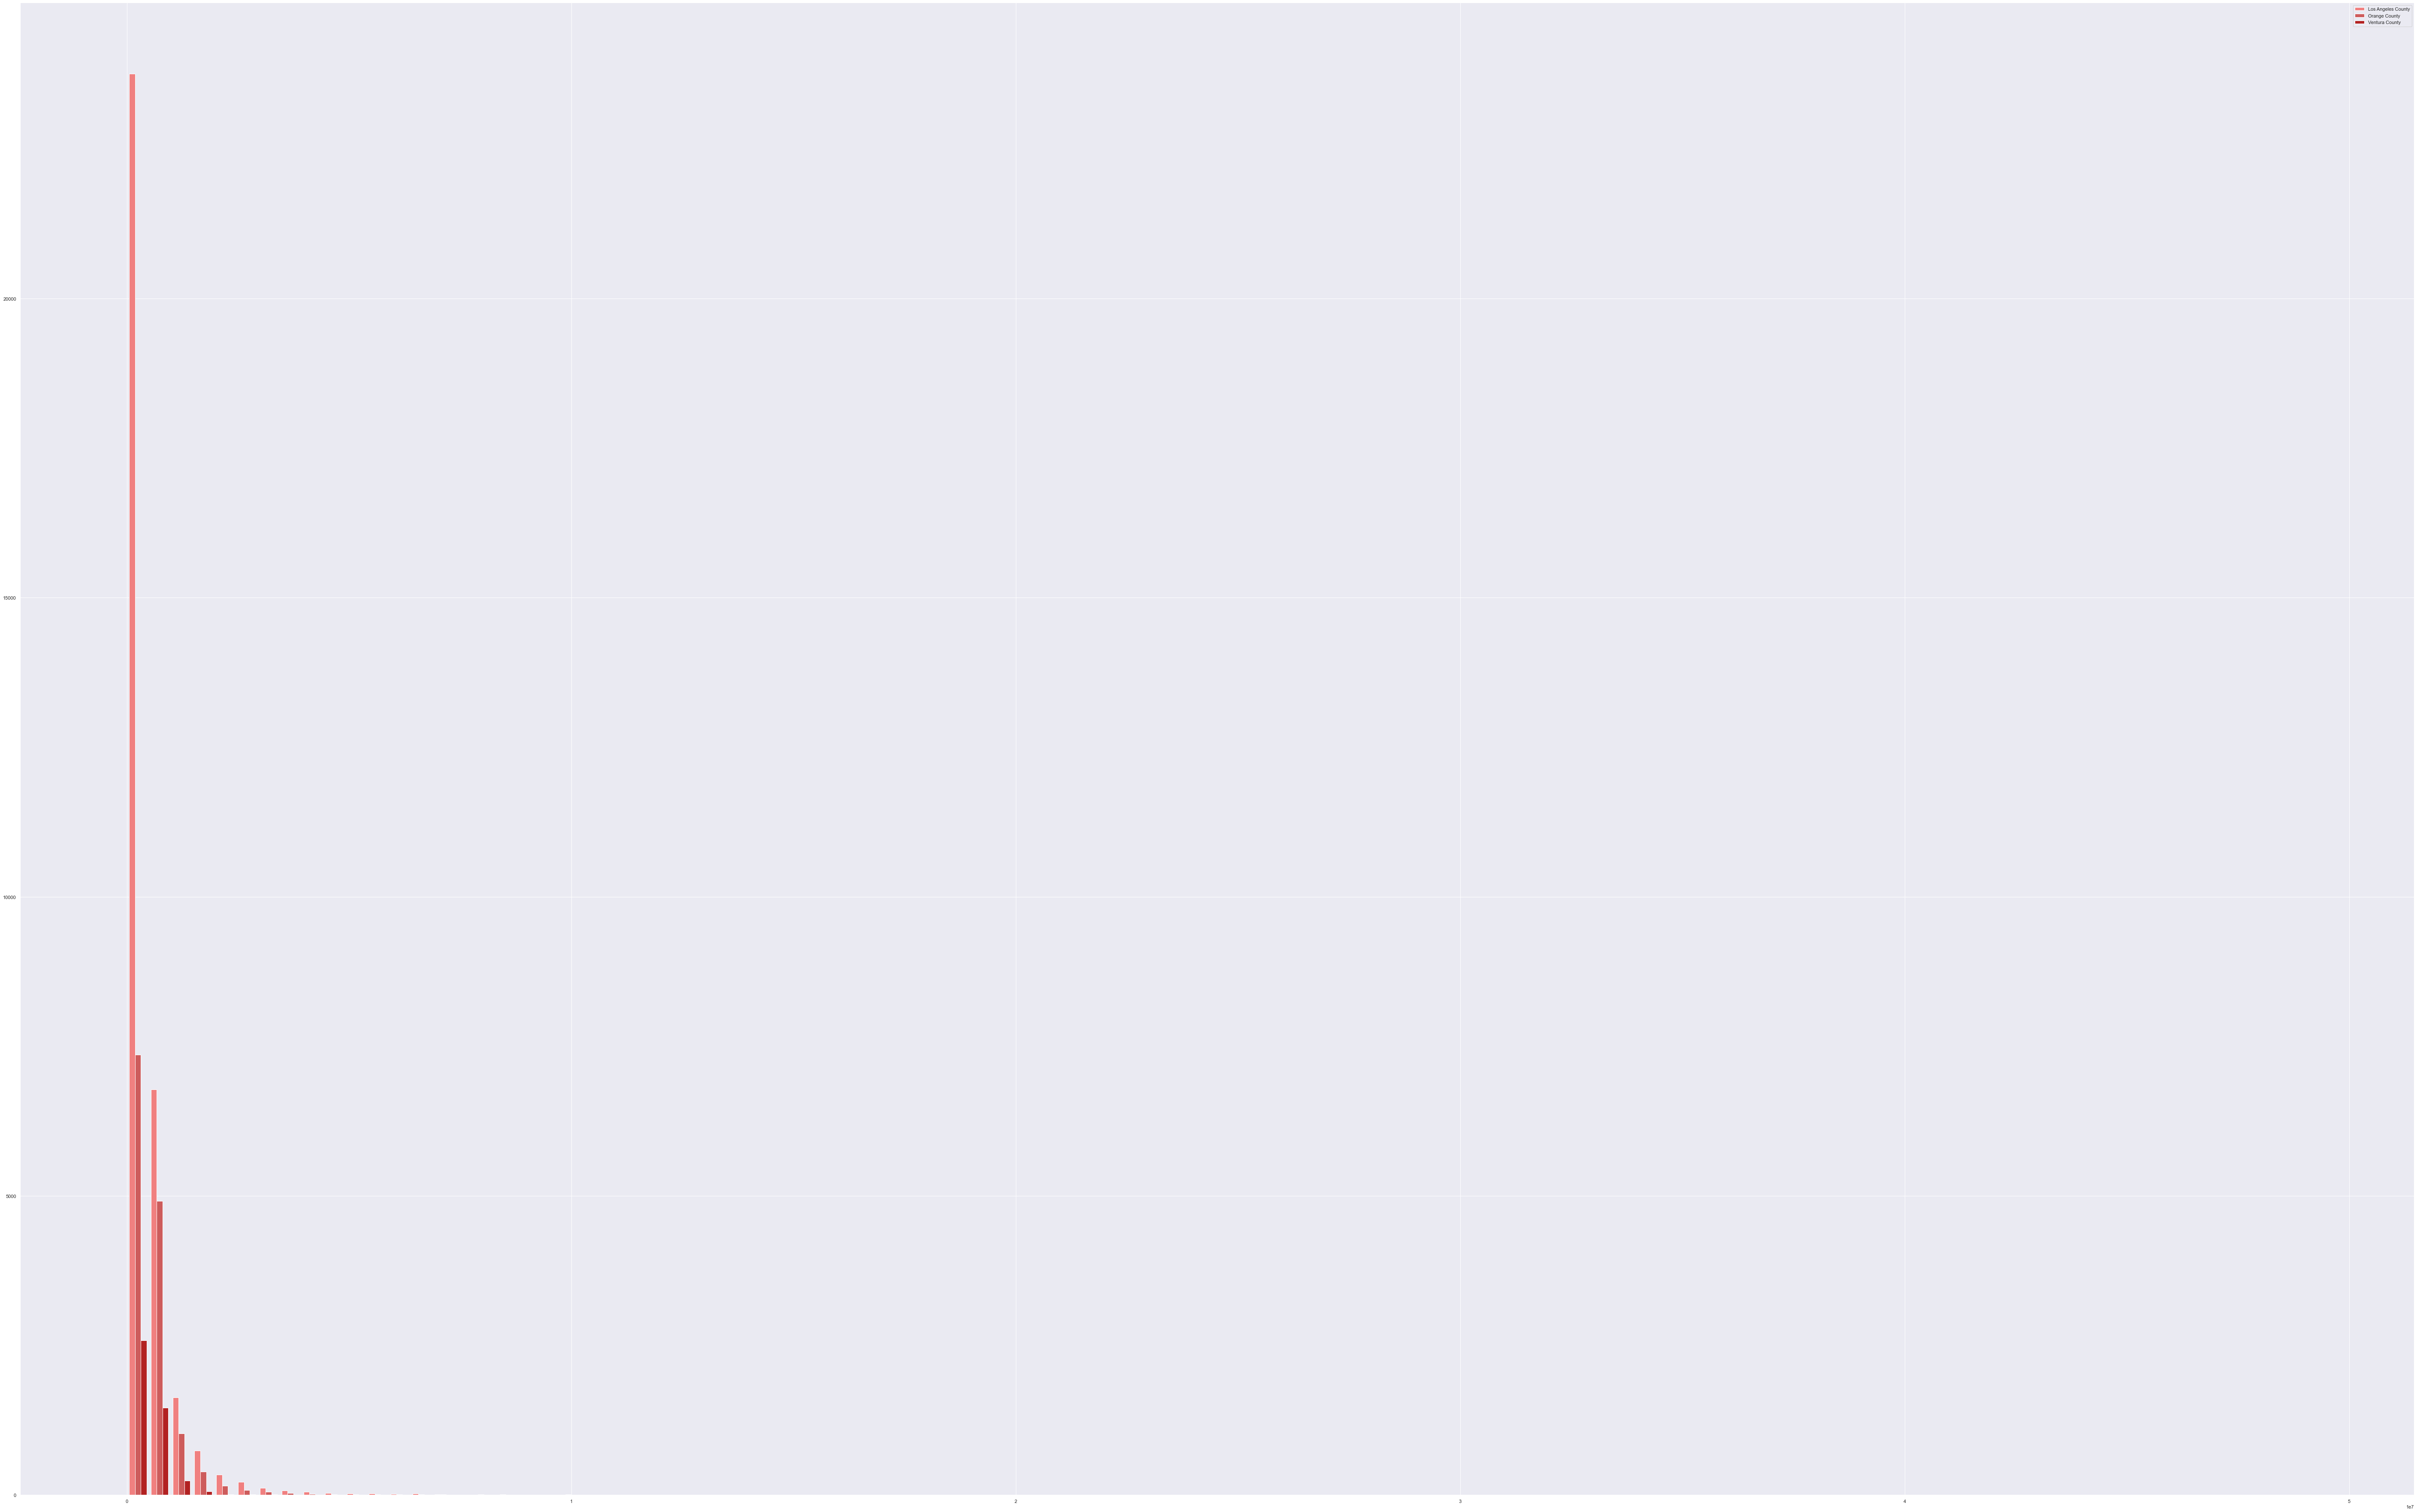

In [70]:
#visualize target variable across different counties
plt.figure(figsize = (100, 64))
plt.hist([los_angeles_county.tax_value, orange_county.tax_value, ventura_county.tax_value],
         label = ['Los Angeles County', 'Orange County', 'Ventura County'],
         color = ['lightcoral', 'indianred', 'firebrick'],
         bins = 100
        )
plt.legend();

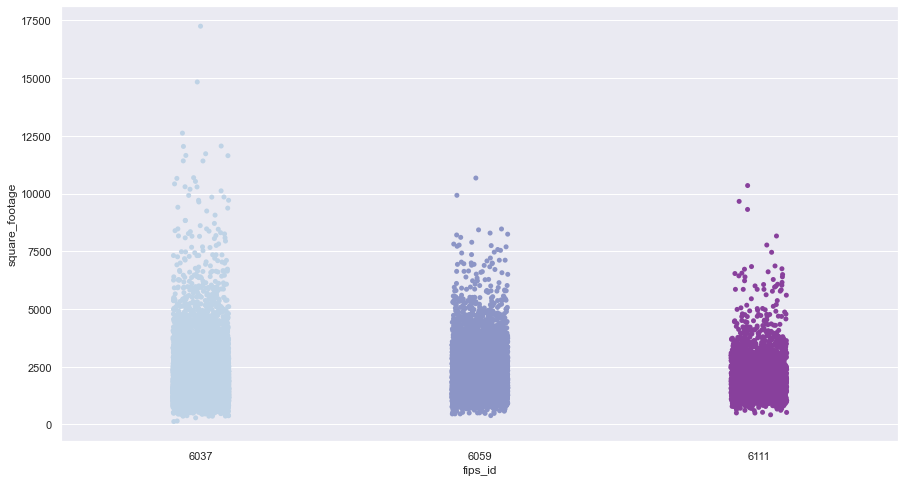

In [27]:
#visualize square footage across counties
plt.figure(figsize = (15, 8))
sns.stripplot(x = 'fips_id', y = 'square_footage', data = train, palette = 'BuPu');

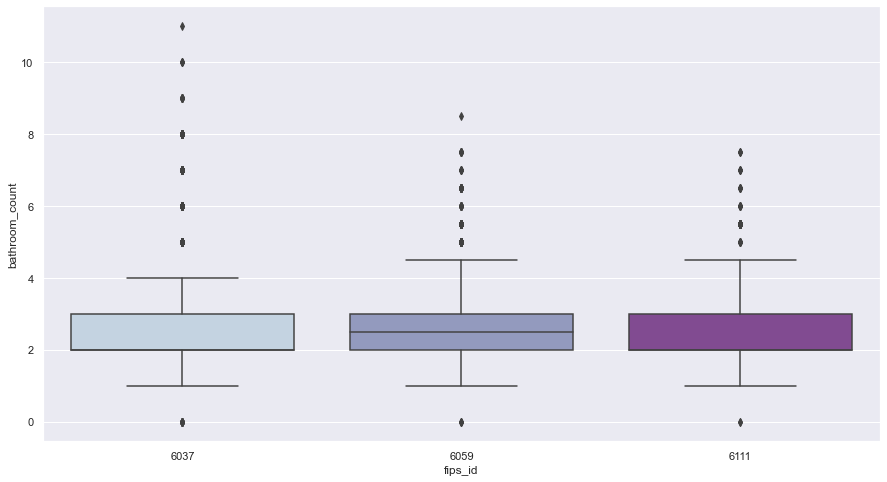

In [28]:
#visualize bathroom count across counties
plt.figure(figsize = (15, 8))
sns.boxplot(x = 'fips_id', y = 'bathroom_count', data = train, palette = 'BuPu');

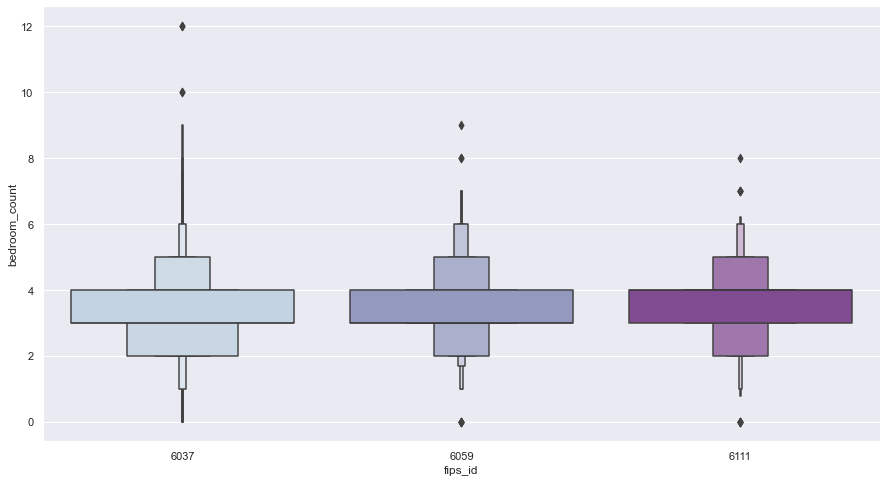

In [29]:
#visualize bedroom count across counties
plt.figure(figsize = (15, 8))
sns.boxenplot(x = 'fips_id', y = 'bedroom_count', data = train, palette = 'BuPu');

In [30]:
#create object
scaler = sklearn.preprocessing.RobustScaler()

#fit object
scaler.fit(train[quant_vars])

#transform data
train_scaled = scaler.transform(train[quant_vars])
validate_scaled = scaler.transform(validate[quant_vars])
test_scaled = scaler.transform(test[quant_vars])

In [31]:
train[['bathroom_count_scaled', 'bedroom_count_scaled', 'square_footage_scaled']] = train_scaled
validate[['bathroom_count_scaled', 'bedroom_count_scaled', 'square_footage_scaled']] = validate_scaled
test[['bathroom_count_scaled', 'bedroom_count_scaled', 'square_footage_scaled']] = test_scaled

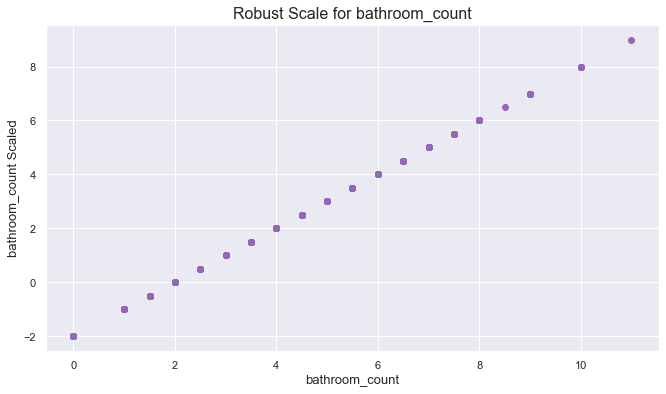

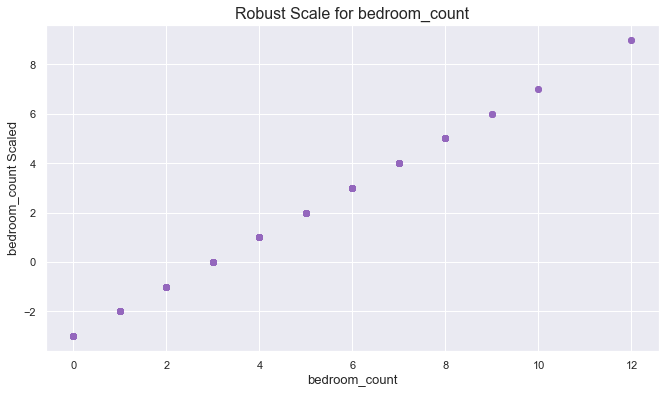

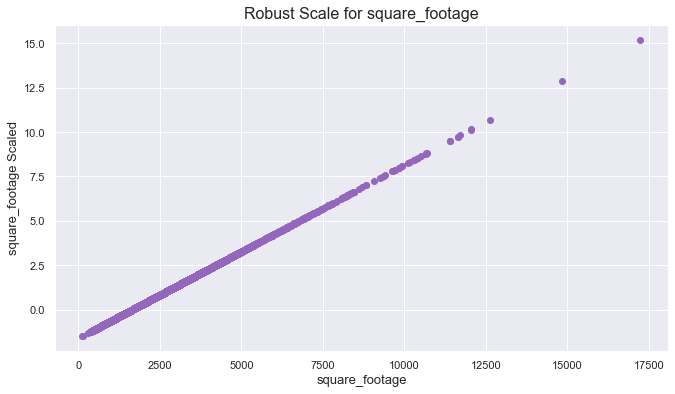

In [32]:
#visualize the scale
for cat in quant_vars:
    plt.figure(figsize = (11, 6))
    plt.scatter(train[cat], train[f'{cat}_scaled'], color = 'tab:purple')
    plt.xlabel(cat, size = 13)
    plt.ylabel(f'{cat} Scaled', size = 13)
    plt.title(f'Robust Scale for {cat}', size = 16)
    plt.grid(True);

In [33]:
scaled = ['bathroom_count_scaled', 'bedroom_count_scaled', 'square_footage_scaled']

In [34]:
#set up modeling data
X_train = train[scaled]
y_train = train.tax_value

X_validate = validate[scaled]
y_validate = validate.tax_value

X_test = test[scaled]
y_test = test.tax_value

In [35]:
#let's start with the best feature and then some
f_select = SelectKBest(f_regression, k = 1)

#fit it
f_select.fit(X_train, y_train)

#create a boolean mask to show if feature was selected
feat_mask = f_select.get_support()

#gimme best feature
best_feature = X_train.iloc[:,feat_mask].columns.to_list()

In [36]:
best_feature

['square_footage_scaled']

In [37]:
# and then some
f_select = SelectKBest(f_regression, k = 2)

#fit it
f_select.fit(X_train, y_train)

#create a boolean mask to show if feature was selected
feat_mask = f_select.get_support()

#gimme best feature
best_features = X_train.iloc[:,feat_mask].columns.to_list()

In [38]:
#best two features?
best_features

['bathroom_count_scaled', 'square_footage_scaled']

In [39]:
#set a baseline
round(train.tax_value.mean(), 2)

521759.74

In [40]:
train['baseline'] = train.tax_value.mean()
baseline = train.tax_value.mean()

In [41]:
#let's rock and roll
ols_I = LinearRegression(normalize = True)

#fit it
ols_I.fit(X_train[['square_footage_scaled']], y_train)

#predict
train['y_hat'] = ols_I.predict(X_train[['square_footage_scaled']])

In [42]:
train.head()

,fips_id,bathroom_count,bedroom_count,square_footage,tax_value,bathroom_count_scaled,bedroom_count_scaled,square_footage_scaled,baseline,y_hat
parcel_id,,,,,,,,,,
14390919,6059,3.0,4.0,2081.0,669010.0,1.0,1.0,0.413659,521759.738097,589541.904997
11864959,6037,1.0,2.0,838.0,159143.0,-1.0,-1.0,-0.799024,521759.738097,65449.506188
17244722,6111,2.0,4.0,1263.0,167977.0,0.0,1.0,-0.384390,521759.738097,244644.413263
10762157,6037,2.0,2.0,1281.0,326341.0,0.0,-1.0,-0.366829,521759.738097,252233.844621
11941236,6037,3.0,3.0,1644.0,634915.0,1.0,0.0,-0.012683,521759.738097,405287.377017


In [43]:
evaluate.regression_errors(train.tax_value, train.y_hat)

Model Metrics


SSE     9.093007e+15
ESS     5.176577e+15
TSS     1.426958e+16
MSE     3.101298e+11
RMSE    5.568930e+05
dtype: float64

In [44]:
evaluate.baseline_mean_errors(train.tax_value)

Baseline Metrics
----------------


SSE     1.426958e+16
MSE     4.866843e+11
RMSE    6.976276e+05
dtype: float64

In [45]:
evaluate.better_than_baseline(train.tax_value, train.y_hat)

True

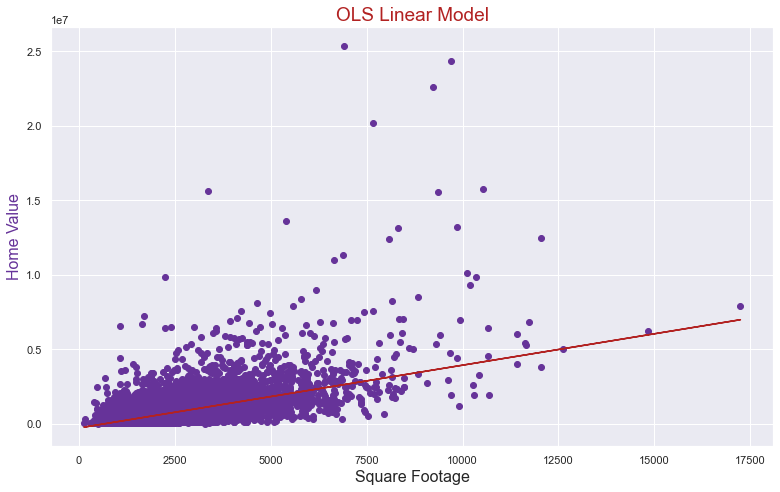

In [82]:
#figure
plt.figure(figsize = (11, 7))

#scatterplot of original x and y
plt.scatter(train.square_footage, train.tax_value, color = 'rebeccapurple')

#lineplot of predicted values
plt.plot(train.square_footage, train.y_hat, color = 'firebrick')

#clarity
plt.xlabel('Square Footage', size = 16)
plt.ylabel('Home Value', color = 'rebeccapurple', size = 16)
plt.title('OLS Linear Model', color = 'firebrick', size = 19)
plt.tight_layout();

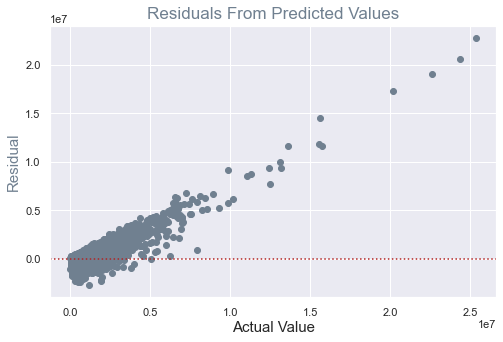

In [46]:
evaluate.plot_residuals(train.tax_value, train.y_hat)

I don't like this model, even if it is better than the baseline

In [78]:
#let's roll
ols_II = LinearRegression(normalize = True)

#fit it
ols_II.fit(X_train[['square_footage_scaled', 'bathroom_count_scaled']], y_train)

#predict
train['y_hatII'] = ols_II.predict(X_train[['square_footage_scaled', 'bathroom_count_scaled']])

In [68]:
train_scaled.inverse

AttributeError: 'Series' object has no attribute 'inverse_transform_'

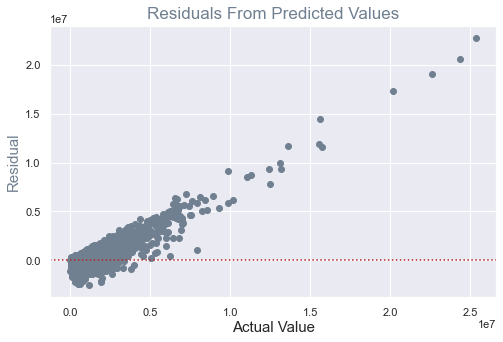

In [48]:
evaluate.plot_residuals(y_train, train.y_hatII)

In [49]:
evaluate.regression_errors(y_train, train.y_hatII)

Model Metrics


SSE     9.085539e+15
ESS     5.184045e+15
TSS     1.426958e+16
MSE     3.098751e+11
RMSE    5.566643e+05
dtype: float64

In [50]:
#let's
ols_III = LinearRegression(normalize = True)

#fit it
ols_III.fit(X_train, y_train)

#predict
train['y_hatIII'] = ols_III.predict(X_train)

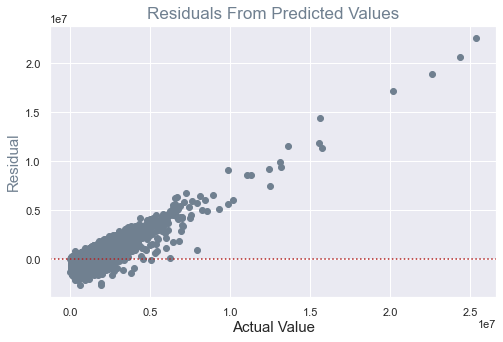

In [51]:
evaluate.plot_residuals(y_train, train.y_hatIII)

In [52]:
evaluate.regression_errors(y_train, train.y_hatIII)

Model Metrics


SSE     8.808612e+15
ESS     5.460972e+15
TSS     1.426958e+16
MSE     3.004301e+11
RMSE    5.481151e+05
dtype: float64

### Takeaways
* you cannot get away with estimating a house's value based solely on square footage and bathroom and bedroom counts with this range of values
